In [1]:
from  nilearn import plotting
%matplotlib inline
import os
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
import pandas as pd

Failed to import duecredit due to No module named 'duecredit'
/home/zohyos7/anaconda3/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
experiment_dir  = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

task_list = ['affect']

In [4]:
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')

subject_list = [sub[-4:] for sub in subject_list]

In [5]:
# TR of functional images
TR = 2

# Smoothing withds used during preprocessing
fwhm = [4, 8]

In [6]:
# SpecifyModel - Generates SPM-specific Model# Speci 
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [7]:
# Condition names# Condi 
condition_names = ['Neutral','Positive','Negative']

# Contrasts
cont01 = ['Average', 'T', condition_names, [1/3.,1/3.,1/3.]]
cont02 = ['Neutral', 'T', condition_names, [1, 0, 0]]
cont03 = ['Positive', 'T', condition_names, [0, 1, 0]]
cont04 = ['Negative', 'T', condition_names, [0, 0, 1]]
cont05 = ['Neutral > Others', 'T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Positive > Others', 'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Negative > Others', 'T', condition_names, [-0.5, -0.5, 1]]
cont08 = ['Neutral > Positive','T', condition_names, [1,-1, 0]]
cont09 = ['Neutral > Negative','T', condition_names, [1,0,-1]]
cont10 = ['Positive > Negative','T', condition_names, [0,1,-1]]

cont11 = ['activation', 'F', [cont02, cont03, cont04]]
cont12 = ['differences_1', 'F', [cont05, cont06, cont07]]
cont13 = ['differences_2', 'F', [cont08, cont09, cont10]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09, cont10, cont11, cont12, cont13]

In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/wellbeing_bids/sub-%s/func/sub-%s_task-affect_events.tsv' % (subject_id,subject_id))
    trialinfo['iCond'] = trialinfo['iCond'].apply({1:'Neutral',2:'Positive',3:'Negative'}.get)
    trialinfo.head()
    d = {'Neutral':1,'Positive':2,'Negative':3}
    conditions = []
    onsets = []
    durations = []

    for group in sorted(trialinfo.groupby('iCond'), key=lambda x:d[x[0]]):
        conditions.append(group[0])
        onsets.append(list(group[1].onset))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations)]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'task_name',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                         'fwhm-{fwhm_id}_sasub-{subject_id}_task-{task_name}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                             'asub-{subject_id}_task-{task_name}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}', 
                             'art.asub-{subject_id}_task-{task_name}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_fwhm_id_%s_subject_id_%s_task_name_affect' % (f, sub), 
                  'sub-%s/task-affect/fwhm-%s/' % (sub, f))
                 for f in fwhm
                 for sub in subject_list]
datasink.inputs.substitutions = substitutions

In [10]:

# Initiation of the 1st-level analysis workflow# Initi 
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('task_name', 'task_name'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

180929-16:22:51,81 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


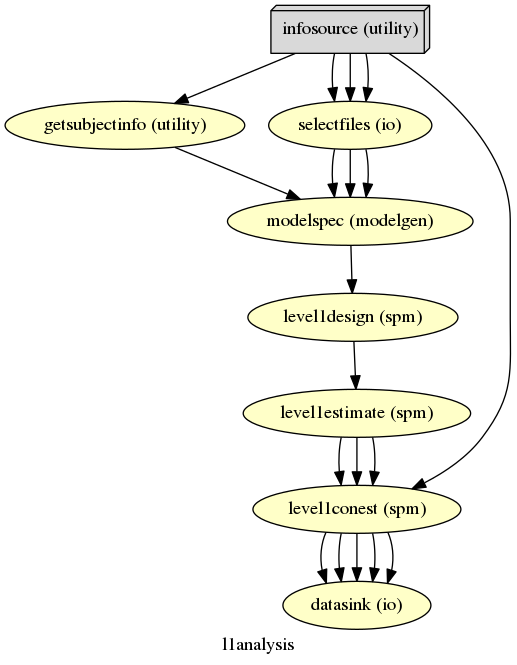

In [11]:
# Create 1st-level analysis output graph# Creat 
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

In [ ]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 10})

180929-16:22:54,895 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
180929-16:23:04,646 nipype.workflow INFO:
	 Running in parallel.
180929-16:23:04,735 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 996 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 10/10.
180929-16:23:04,899 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2677_task_name_affect/selectfiles".
180929-16:23:04,912 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
180929-16:23:04,917 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3140_task_name_affect/getsubjectinfo".180929-16:23:04,917 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subj

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3140_task_name_affect/modelspec/art.asub-3140_task-affect_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3140_task_name_affect/modelspec/art.asub-3140_task-affect_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)



180929-16:23:07,43 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:23:07,46 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
180929-16:23:07,48 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:23:07,52 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:23:07,55 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:23:07,82 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:23:08,740 nipype.workflow INFO:
	 [Job 2] Completed (l1analysis.modelspec).
180929-16:23:08,747 nipype.workflow INFO:
	 [Job 9] Completed (l1analysis.modelspec).
180929-16:23:08,752 nipype.workflow INFO:
	 [Job 16] Completed (l1analysis.modelspec).
180929-16:23:08,756 nipype.workflow INFO:
	 [Job 23] Completed (l1analysis.modelspec).
180929-16:23:08,761 nipype.workflow INFO:
	 [Job 30] Completed (l1analysis.modelspec).
180929-16:23:08,766 nipype.workflow INFO:
	 [Job 35] Completed 

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2607_task_name_affect/modelspec/art.asub-2607_task-affect_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)



180929-16:24:47,279 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
180929-16:24:47,282 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
180929-16:24:47,294 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:24:47,298 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
180929-16:24:48,399 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
180929-16:24:48,832 nipype.workflow INFO:
	 [Job 68] Completed (l1analysis.level1conest).
180929-16:24:48,843 nipype.workflow INFO:
	 [Job 100] Completed (l1analysis.modelspec).
180929-16:24:48,851 nipype.workflow INFO:
	 [Job 106] Completed (l1analysis.getsubjectinfo).
180929-16:24:48,858 nipype.workflow INFO:
	 [Job 112] Completed (l1analysis.selectfiles).
180929-16:24:48,865 nipype.workflow INFO:
	 [Job 113] Completed (l1analysis.getsubjectinfo).
180929-16:24:48,871 nipype.workflow INFO:
	 [Job 119] Completed (l1analysis.s

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2607_task_name_affect/modelspec/art.asub-2607_task-affect_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)




180929-16:24:49,131 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")180929-16:24:49,134 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2666_task_name_affect/selectfiles".
180929-16:24:49,136 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
180929-16:24:49,140 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
180929-16:24:49,149 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
180929-16:24:49,150 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
180929-16:24:49,153 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
180929-16:24:49,159 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
180929-16:24:49,167 nipype.workflow INFO:
	 [Node] Running "datasink" ("n

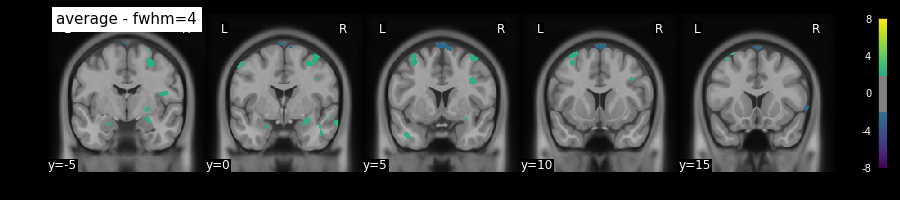

In [145]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
template = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'
plot_stat_map(
    '/data/wellbeing_analysis/datasink/1stLevel/sub-2505/fwhm-4_task_name_empathy/spmT_0009.nii', title='average - fwhm=4',
    bg_img=template, threshold=2, vmax=8, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), cmap = 'viridis');

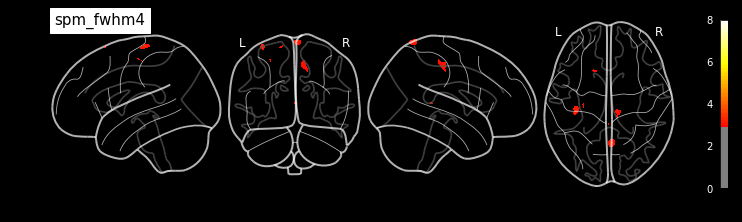

In [146]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/data/wellbeing_analysis/datasink/1stLevel/sub-2505/fwhm-4_task_name_empathy/spmT_0009.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=8, title='spm_fwhm4');

In [134]:
?plot_glass_brain

Signature: plot_glass_brain(stat_map_img, output_file=None, display_mode='ortho', colorbar=False, figure=None, axes=None, title=None, threshold='auto', annotate=True, black_bg=False, cmap=None, alpha=0.7, vmin=None, vmax=None, plot_abs=True, symmetric_cbar='auto', resampling_interpolation='continuous', **kwargs)
Docstring:
Plot 2d projections of an ROI/mask image (by default 3 projections:
Frontal, Axial, and Lateral). The brain glass schematics
are added on top of the image.

The plotted image should be in MNI space for this function to work
properly.

Parameters
----------
stat_map_img : Niimg-like object
    See http://nilearn.github.io/manipulating_images/input_output.html
    The statistical map image. It needs to be in MNI space
    in order to align with the brain schematics.
output_file : string, or None, optional
    The name of an image file to export the plot to. Valid extensions
    are .png, .pdf, .svg. If output_file is not None, the plot
    is saved to a file, and the d